Based on the ode_demo.py file by rickie chen
https://github.com/rtqichen/torchdiffeq

Also, see the paper "Neural Ordinary Differential Equations" (https://arxiv.org/abs/1806.07366)

In [129]:
import matplotlib.pyplot as plt

import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


%matplotlib notebook

# ODE Solver method
method = 'dopri5'
# whole test data
data_size = 1000
# time size of the batch
batch_time = 10
# batche size
batch_size = 20
# number of iterations
niters = 200
# test frequency
test_freq = 20
# gpu nr.
gpu = 0

# adjoint method
adjoint = True
# visualization of the results
viz = True


In [130]:
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

Set up the reference system, second order differential equation of a mass-spring-damper-system

In [131]:
# initial values
true_y0 = torch.tensor([[0., 2.]])
# time
t = torch.linspace(0., 25., data_size)
# Matrix state space
m = 1
d = 1
k = 1
# true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])
true_A_T = torch.tensor([[0.0, 1.0], [-k/m, -d/m]])
true_A = torch.transpose(true_A_T, 0, 1)

class Lambda(nn.Module):

    def forward(self, t, y):
        dydt = torch.mm(y, true_A)
        return dydt

In [132]:
# Calculate the trajectories of the reference system
with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')

In [133]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

if viz:
    makedirs('png')

def visualize(true_y, pred_y, odefunc, itr,ax_traj,ax_phase,ax_vecfield):
    # print('does something')

    if True: #viz:
    #     print('does something')
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(-2, 2)
        #ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-2, 2)
        ax_phase.set_ylim(-2, 2)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(-2, 2)
        ax_vecfield.set_ylim(-2, 2)

        fig.tight_layout()
        # plt.savefig('png/{:03d}'.format(itr))
        # plt.draw()
        fig.canvas.draw()
        plt.pause(0.001)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


Definition of the neural network that determines the derivatives (flow)
Because the original system is linear, also only linear layers are used

In [134]:
# declaration of the neural net
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),
            # nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        dydt = self.net(y)

        return dydt

In the code below, the neural ode is trained on the simulated data

<IPython.core.display.Javascript object>


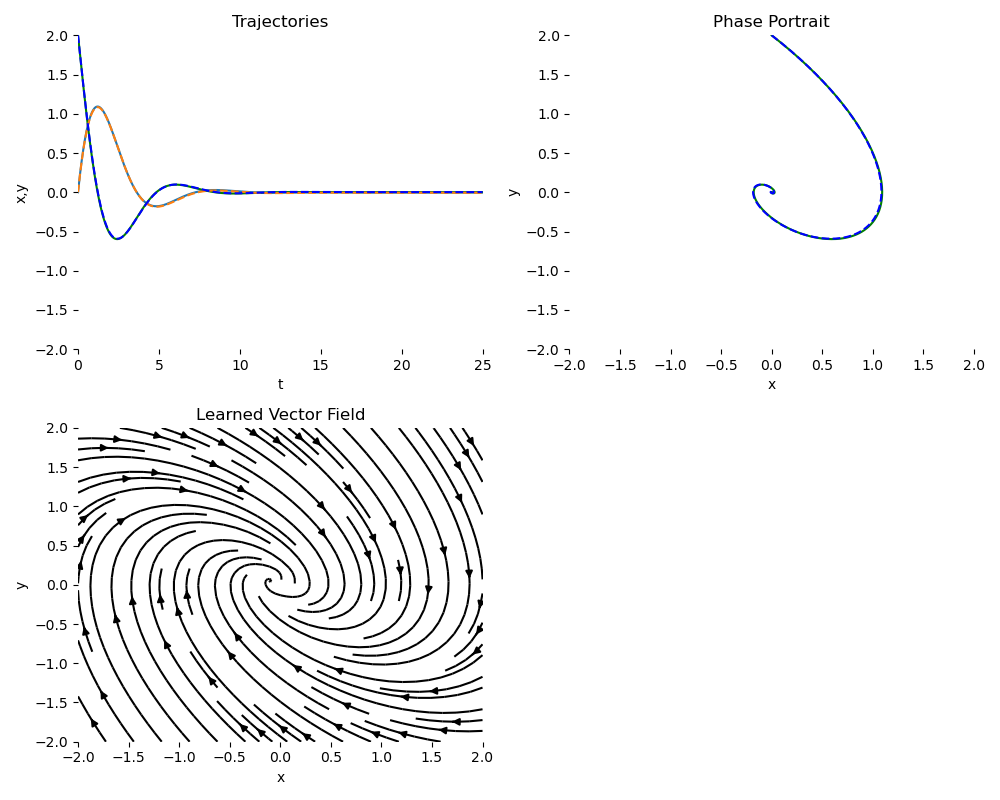

Iter 0020 | Total Loss 0.248613
Iter 0040 | Total Loss 0.131990
Iter 0060 | Total Loss 0.015414
Iter 0080 | Total Loss 0.004326
Iter 0100 | Total Loss 0.003654
Iter 0120 | Total Loss 0.005455
Iter 0140 | Total Loss 0.003373
Iter 0160 | Total Loss 0.004529
Iter 0180 | Total Loss 0.004041
Iter 0200 | Total Loss 0.004507


In [135]:
ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

fig = plt.figure(figsize=(10, 8), facecolor='white')
ax_traj = fig.add_subplot(221, frameon=False)
ax_phase = fig.add_subplot(222, frameon=False)
ax_vecfield = fig.add_subplot(223, frameon=False)

for itr in range(1, niters + 1):
    # reset gradients
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    # do the predictions
    # print(batch_y0, true_y0)
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii,ax_traj,ax_phase,ax_vecfield)
            ii += 1
            # time.sleep(1)
            #plt.show(block=False)
    end = time.time()